# Example for:
Clustering Experiment from from Vehicles (pretraining) to Animals (finetuning) classes of CIFAR

# Setup and utils

In [1]:
import sys
sys.path.append('/home/arnisaf/mp-tl-study')
from functions.utils import *
from functions.clustering_utils import *
from functions.visualization_utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3,4,5]

### Load the pretrained model as a feature extractor

In [4]:
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 6,
      'num_channels': 64,
      'width':64,
      # 'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 3,
      # TRAINING PARAMS
      'device': device,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 10,
      'early_stop_patience': 5,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':64,
      # DATASET PARAMS
      'pre_train_classes': [0, 1, 8, 9],
      'fine_tune_classes': [2, 3, 4, 5, 6, 7],
        'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'use_pooling': True,   # CHANGE
      'pooling_every_n_layers': 2, # add pooling after every n layers specified here. For only one pooling after all the CNN layers, this equals params['depth']
      'pooling_stride': 2,
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': True,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True,   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
      'truncate': False
    }

In [5]:
root_dir = './data'  # Specify your data directory here
transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
dataloader_wrapped = TransferLearningWrapper(params, datasets.CIFAR10, datasets.CIFAR10, root_dir, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
feature_extractor = CNNFeatureExtractor(params, dataloader_wrapped.output_dim, input_shape=tuple(dataloader_wrapped.finetune_test_loader.dataset[0][0].shape)).to(device)
feature_extractor.load_state_dict(torch.load('pretrained_models/pretrained_model_Vehicles_constant_channels/modelcifar10_vehicles_cpu.pth'))

<All keys matched successfully>

### tSNE Visualizations

In [10]:
dataloader_wrapped.update_phase('pretrain')

# Extract features and labels using the feature extractor model and the test_loader
train_extracted_features, train_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)
val_extracted_features, val_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.val_loader, device)
test_extracted_features, test_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.test_loader, device)

In [11]:
# sanity check
print(train_labels[:10])
print(torch.argmax(train_extracted_features["fc"][:10], dim=1))
print(test_labels[:10])
print(torch.argmax(test_extracted_features["fc"][:10], dim=1))

tensor([2., 1., 3., 0., 2., 3., 3., 1., 1., 3.])
tensor([2, 1, 3, 0, 2, 3, 3, 1, 1, 3])
tensor([3., 3., 1., 1., 2., 3., 3., 3., 0., 0.])
tensor([3, 3, 1, 1, 2, 3, 3, 3, 0, 0])


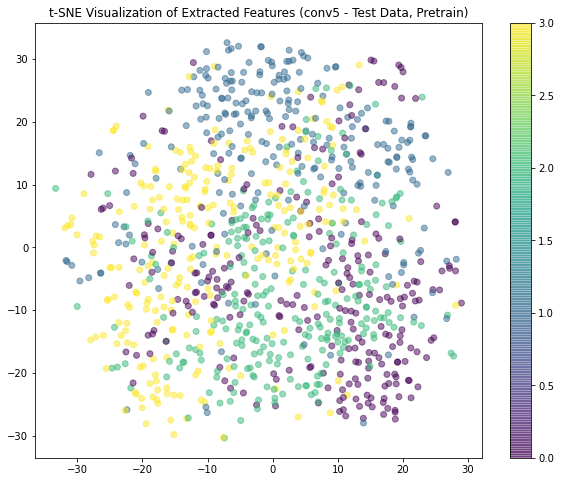

ARI of multidimensional KNN:  0.1917138922339245


In [16]:
# Visualize t-SNE for each layer in training data
# for layer_name, layer_features in train_extracted_features.items():
#    visualize_tsne(layer_features, train_labels, layer_name, "Training Data")

layer_name = "conv5"
layer_features = test_extracted_features[layer_name][:1000,0,:,:].unsqueeze(1)
# layer_features = test_extracted_features[layer_name][:1000,:].unsqueeze(1)
visualize_tsne(layer_features, test_labels[:1000], layer_name, "Test Data, Pretrain")
# Repeat for validation and test data if needed
ari = calculate_ARI_score(layer_features, test_labels[:1000])
print("ARI of multidimensional KNN: ", ari)

In [44]:
dataloader_wrapped.update_phase('finetune')

# Extract features and labels using the feature extractor model and the test_loader
train_extracted_features, train_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)
val_extracted_features, val_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.val_loader, device)
test_extracted_features, test_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.test_loader, device)

<All keys matched successfully>

In [45]:
# Visualize t-SNE for each layer in training data
# for layer_name, layer_features in train_extracted_features.items():
#    visualize_tsne(layer_features, train_labels, layer_name, "Training Data")

layer_name = "conv3"
layer_features = test_extracted_features[layer_name][-100:,0,:,:].unsqueeze(1)
# layer_features = test_extracted_features[layer_name][:1000,:].unsqueeze(1)
visualize_tsne(layer_features, test_labels[-100:], layer_name, "Test Data, Fine Tune")
# Repeat for validation and test data if needed
ari = calculate_ARI_score(layer_features, test_labels[-100:])
print("ARI of multidimensional KNN: ", ari)

In [82]:
from sklearn.metrics import davies_bouldin_score, pairwise_distances

dataloader_wrapped.update_phase('pretrain')
extracted_features, labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)

layer_names = extracted_features.keys()
results = {}

for layer_name in layer_names:
    features = extracted_features[layer_name]
    X = features.view(features.size(0), -1).numpy()
    distances = pairwise_distances(X, metric='cosine')

    # Calculate mean intra-cluster distances for each cluster
    mean_intra_cluster_distances = {}
    for cluster_label in np.unique(labels):
        cluster_mask = labels == cluster_label
        intra_cluster_distances = distances[cluster_mask][:, cluster_mask]
        mean_intra_cluster_distance = np.mean(intra_cluster_distances)
        mean_intra_cluster_distances[cluster_label] = mean_intra_cluster_distance

    # Calculate mean inter-cluster distance
    inter_cluster_distances = distances[~np.eye(len(X), dtype=bool)].reshape(len(X), -1)
    mean_inter_cluster_distance = np.mean(inter_cluster_distances)
    results[layer_name] = {"mean_intra_cluster_distances":mean_intra_cluster_distances, "mean_inter_cluster_distance":mean_inter_cluster_distance}


In [83]:
results

{'conv0': {'mean_intra_cluster_distances': {0.0: 0.4413703,
   1.0: 0.7016706,
   2.0: 0.436234,
   3.0: 0.6198644},
  'mean_inter_cluster_distance': 0.5641237},
 'conv1': {'mean_intra_cluster_distances': {0.0: 0.15754253,
   1.0: 0.15221407,
   2.0: 0.16765083,
   3.0: 0.15024886},
  'mean_inter_cluster_distance': 0.158983},
 'conv2': {'mean_intra_cluster_distances': {0.0: 0.21357286,
   1.0: 0.2468711,
   2.0: 0.17918119,
   3.0: 0.24392056},
  'mean_inter_cluster_distance': 0.224315},
 'conv3': {'mean_intra_cluster_distances': {0.0: 0.18800181,
   1.0: 0.19752422,
   2.0: 0.20237385,
   3.0: 0.21967456},
  'mean_inter_cluster_distance': 0.20734248},
 'conv4': {'mean_intra_cluster_distances': {0.0: 0.10129656,
   1.0: 0.12543947,
   2.0: 0.100264184,
   3.0: 0.10309075},
  'mean_inter_cluster_distance': 0.115354694},
 'conv5': {'mean_intra_cluster_distances': {0.0: 0.099694856,
   1.0: 0.11716424,
   2.0: 0.099762216,
   3.0: 0.09597312},
  'mean_inter_cluster_distance': 0.11497472},

In [84]:
for layer, result in results.items():
    mean_intra_cluster_distance = np.average(list(result["mean_intra_cluster_distances"].items()))
    print(f"{layer}: mean_inter_cluster_distance/mean_intra_cluster_distance = {result['mean_inter_cluster_distance']/mean_intra_cluster_distance}")

conv0: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.5504223108291626
conv1: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.1919025480747223
conv2: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.26069706678390503
conv3: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.24366091191768646
conv4: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.1435185819864273
conv5: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.14343614876270294
fc: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.38075053691864014
input: mean_inter_cluster_distance/mean_intra_cluster_distance = 0.7753034830093384


In [47]:
extracted_features, labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)

In [40]:
x = out_features["conv0"]
torch.mean(x, dim=(1)).shape

torch.Size([56, 32, 32])

### tSNE Visualizations

In [27]:
dataloader_wrapped.update_phase('pretrain')

# Extract features and labels using the feature extractor model and the test_loader
train_extracted_features, train_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)
val_extracted_features, val_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.val_loader, device)
test_extracted_features, test_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.test_loader, device)

In [23]:
# sanity check
print(train_labels[:10])
print(torch.argmax(train_extracted_features["fc"][:10], dim=1))
print(test_labels[:10])
print(torch.argmax(test_extracted_features["fc"][:10], dim=1))

[2, 3, 3, 0, 3, 4, 3, 3, 2, 5]
tensor([2, 3, 3, 0, 3, 4, 3, 3, 2, 5])
[2, 1, 1, 5, 1, 4, 5, 4, 3, 4]
tensor([2, 1, 1, 5, 1, 4, 5, 4, 3, 4])


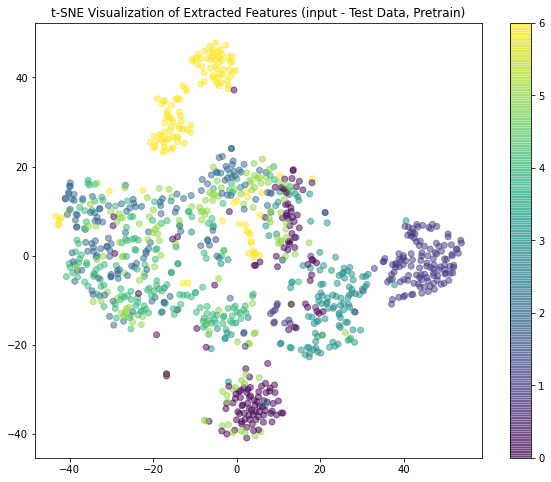

ARI of multidimensional KNN:  0.25170979240155095


In [24]:
# Visualize t-SNE for each layer in training data
# for layer_name, layer_features in train_extracted_features.items():
#    visualize_tsne(layer_features, train_labels, layer_name, "Training Data")

layer_name = "input"
layer_features = test_extracted_features[layer_name][:1000,0,:,:].unsqueeze(1)
# layer_features = test_extracted_features[layer_name][:1000,:].unsqueeze(1)
visualize_tsne(layer_features, test_labels[:1000], layer_name, "Test Data, Pretrain")
# Repeat for validation and test data if needed
ari = calculate_ARI_score(layer_features, test_labels[:1000])
print("ARI of multidimensional KNN: ", ari)

In [17]:
dataloader_wrapped.update_phase('finetune')

# Extract features and labels using the feature extractor model and the test_loader
train_extracted_features, train_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.train_loader, device)
val_extracted_features, val_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.val_loader, device)
test_extracted_features, test_labels = extract_features_and_labels(feature_extractor, dataloader_wrapped.test_loader, device)

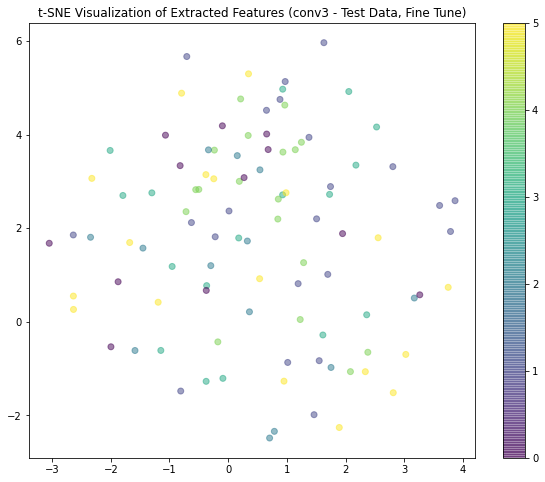

ARI of multidimensional KNN:  0.014156054735182062


In [19]:
layer_name = "conv3"
layer_features = test_extracted_features[layer_name][-100:,0,:,:].unsqueeze(1)
# layer_features = test_extracted_features[layer_name][:1000,:].unsqueeze(1)
visualize_tsne(layer_features, test_labels[-100:], layer_name, "Test Data, Fine Tune")
# Repeat for validation and test data if needed
ari = calculate_ARI_score(layer_features, test_labels[-100:])
print("ARI of multidimensional KNN: ", ari)

### ARI Scores Plot

In [18]:
ari_scores_all = []

In [ ]:
dataloader_wrapped.update_phase('finetune')
dataset_to_use = dataloader_wrapped.train_loader
num_samples = 1000
channel_ids = range(params["num_channels"])
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
layer_names = ["input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'fc']

ari_scores_all = []
# subset the dataset (same as the empirical experiment)
for sampled_percentage in percentages:
    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 5
    print(f"Percentage:{sampled_percentage}")

    for repeat in tqdm(range(repeats)):
        reduced_dataset = reduce_dataset(dataset_to_use, sampled_percentage, seed=repeat)
        if num_samples < len(reduced_dataset.dataset):
            num_samples_tmp = num_samples
        else:
            num_samples_tmp = 0
        pretraining_ari_scores = get_ARI_scores(feature_extractor, reduced_dataset,num_samples_tmp, channel_ids, device)

        # get the max of the channels -append to another dict
        for layer, channels in pretraining_ari_scores.items():
            max_channel = max(channels.items())
            ari_scores_all.append({"Percentage":sampled_percentage, "Repeat":repeat, "Num Samples":num_samples_tmp, "Layer":layer, 
                                   "Max ARI Score":np.max(list(channels.items())), "Avg ARI Score":np.average(list(channels.items())),
                                   "Dataset":"Pretrain", "Split":"Train"})
# dict to df
df = pd.DataFrame(ari_scores_all)

In [ ]:
with open(f'results/ari_scores/finetuning_cifar_regular_classes.json', 'w') as f:
    json.dump(ari_scores_all, f)

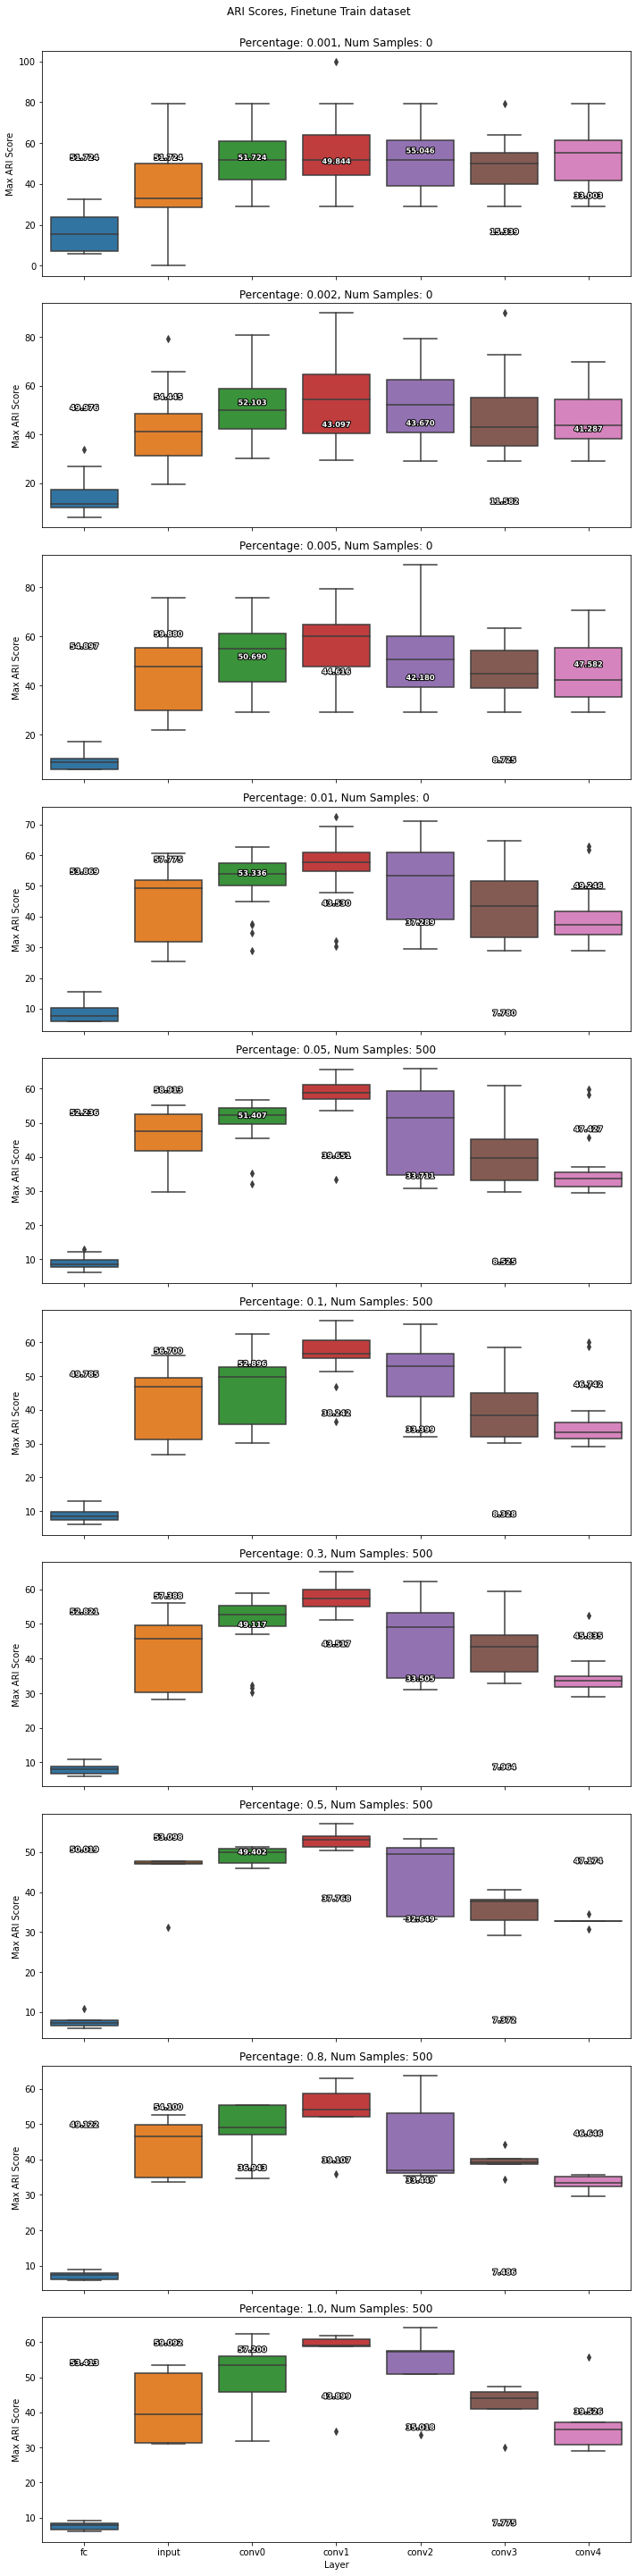

In [18]:
layer_names = ['fc', "input", 'conv0', 'conv1', 'conv2', 'conv3', 'conv4']
plot_ARI_scores_percentages(df, "Finetune", "Train", order=layer_names)